Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/25
3317/3317 [==============================] - 59s 17ms/step - loss: 0.0421
Epoch 2/25
3317/3317 [==============================] - 56s 17ms/step - loss: 0.0345
Epoch 3/25
3317/3317 [==============================] - 56s 17ms/step - loss: 0.0331
Epoch 4/25
3317/3317 [==============================] - 58s 17ms/step - loss: 0.0325
Epoch 5/25
3317/3317 [==============================] - 56s 17ms/step - loss: 0.0322
Epoch 6/25
3317/3317 [==============================] - 56s 17ms/step - loss: 0.0321
Epoch 7/25
3317/3317 [==============================] - 56s 17ms/step - loss: 0.0319
Epoch 8/25
3317/3317 [==============================] - 57s 17ms/step - loss: 0.0318
Epoch 9/25
3317/3317 [==============================] - 57s 17ms/step - loss: 0.0316
Epoch 10/25
3317/3317 [==============================] - 58s 17ms/step - loss: 0.0315
Epoch 11/25
3317/331

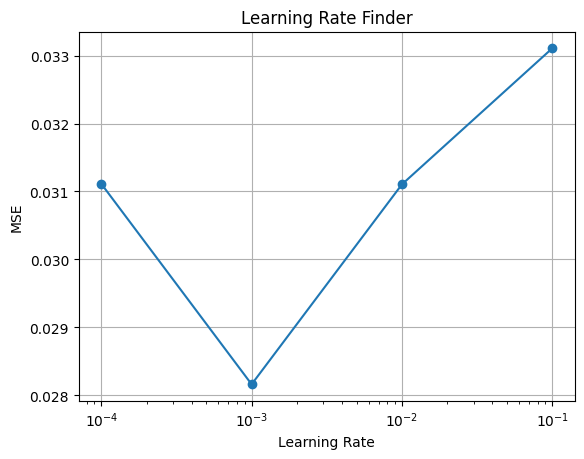

Optimal Learning Rate: 0.001


In [8]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,  Flatten, Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Define the path to the directory containing the feature files
directory_path = '/content/drive/MyDrive/FYP_dataset/features'

# Get a list of all feature file paths in the directory
feature_files = glob.glob(directory_path + '/*.csv')

# Define lists to store the feature and target data
X = []
y_a = []

# Iterate over each feature file
for file in feature_files:
    # Read the feature file into a DataFrame
    df = pd.read_csv(file)

    # Extract the features and target variables
    features = df.drop(['Arousal_Value', 'frameTime'], axis=1).values
    arousal = df['Arousal_Value'].values

    # Append the data to the lists
    X.append(features)
    y_a.append(arousal)

# Concatenate the feature and target arrays
X = np.concatenate(X)
y_a = np.concatenate(y_a)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the input data for LSTM
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Initialize lists to store learning rates and corresponding losses
learning_rates_list = []
losses = []

# Define the learning rates to try
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]

# Loop over learning rates to find the optimal one
for lr in learning_rates:
    # Build the BiLSTM model for Arousal
    model_a = Sequential()
    model_a.add(Bidirectional(CuDNNLSTM(64, return_sequences=True), input_shape=(X_reshaped.shape[1], 1)))
    model_a.add(Flatten())
    model_a.add(Dense(1))
    model_a.compile(loss='mse', optimizer=Adam(learning_rate=lr))

    # Train the Arousal model
    model_a.fit(X_reshaped, y_a, epochs=25, batch_size=32)

    # Evaluate the model on the training set
    predictions_a = model_a.predict(X_reshaped)

    # Calculate MSE loss
    mse_a = mean_squared_error(y_a, predictions_a)

    # Store the learning rate and final loss
    learning_rates_list.append(lr)
    losses.append(mse_a)

# Plot learning rates vs. losses
plt.plot(learning_rates_list, losses, marker='o')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.title('Learning Rate Finder')
plt.grid(True)
plt.show()

# Select the optimal learning rate
optimal_lr = learning_rates_list[np.argmin(losses)]
print(f'Optimal Learning Rate: {optimal_lr}')
